In [54]:
import numpy as np
import pandas as pd
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


In [55]:
import os
# %pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile


os.environ['KAGGLE_CONFIG_DIR'] = '/path/to/your/kaggle.json'

api = KaggleApi()
api.authenticate()

api.competition_download_files('digit-recognizer', path='./')

print("Download complete!")


with zipfile.ZipFile('./digit-recognizer.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print("Unzipping complete!")

Download complete!
Unzipping complete!


Shape of X_train:  (42000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


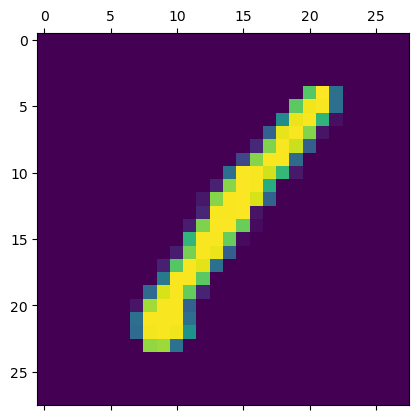

In [56]:
import pandas as pd


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


y_train = train["label"].values
x_train = train.drop(columns=["label"]).values
x_train = x_train / 255.0
x_train_reshaped = x_train.reshape(-1, 28, 28)

x_test = test.values
y_test = None

x_test = x_test / 255.0
x_test_reshaped = x_test.reshape(-1, 28, 28)
X_train = x_train_reshaped.reshape(x_train_reshaped.shape[0], -1)  # Flatten the images to (m, 784)

print("Shape of X_train: ", X_train.shape)

plt.matshow(x_train_reshaped[0])


train.head()

In [57]:
def init_params(input_size, hidden_sizes, output_size):
    params = {}
    layer_sizes = [input_size] + hidden_sizes + [output_size]
    for i in range(len(layer_sizes) - 1):
        params['W' + str(i+1)] = np.random.randn(layer_sizes[i+1], layer_sizes[i]) * 0.01
        params['b' + str(i+1)] = np.zeros((layer_sizes[i+1], 1))
    return params

def relu(Z):
    return np.maximum(0, Z)

def relu_deriv(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Numerical stability
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def one_hot(Y, num_classes=10):
    one_hot_Y = np.zeros((Y.size, num_classes))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T


def forward_prop(X, params):
    caches = {}
    A = X
    L = len(params) // 2  # Number of layers
    for l in range(1, L):
        Z = np.dot(params['W' + str(l)], A) + params['b' + str(l)]
        A = relu(Z)
        caches['Z' + str(l)] = Z
        caches['A' + str(l)] = A
    ZL = np.dot(params['W' + str(L)], A) + params['b' + str(L)]
    AL = softmax(ZL)
    caches['Z' + str(L)] = ZL
    caches['A' + str(L)] = AL
    return AL, caches


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(X, Y, params, caches):
    grads = {}
    L = len(params) // 2
    m = X.shape[1] 
    Y = one_hot(Y)
    
    dA = caches['A' + str(L)] - Y
    for l in range(L, 0, -1):
        dZ = dA * relu_deriv(caches['Z' + str(l)])
        grads['dW' + str(l)] = np.dot(dZ, caches['A' + str(l-1)].T) / m
        grads['db' + str(l)] = np.sum(dZ, axis=1, keepdims=True) / m
        dA = np.dot(params['W' + str(l)].T, dZ)
    
    return grads

def update_params(params, grads, learning_rate):
    L = len(params) // 2
    for l in range(1, L + 1):
        params['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    return params

In [58]:
def train(X_train, Y_train, input_size, hidden_sizes, output_size, epochs, batch_size, learning_rate):
    params = init_params(input_size, hidden_sizes, output_size)
    m = X_train.shape[1]  
    for epoch in range(epochs):
        perm = np.random.permutation(m)
        X_train_shuffled = X_train[:, perm]
        Y_train_shuffled = Y_train[perm]
        
        for i in range(0, m, batch_size):
            X_batch = X_train_shuffled[:, i:i+batch_size]
            Y_batch = Y_train_shuffled[i:i+batch_size]
            
            X_batch = X_batch.reshape(784, -1) 
            
            AL, caches = forward_prop(X_batch, params)
            
            grads = backward_prop(X_batch, Y_batch, params, caches)
            
            params = update_params(params, grads, learning_rate)
        
        if epoch % 10 == 0:
            predictions = np.argmax(AL, axis=0)
            accuracy = np.mean(predictions == Y_train_shuffled)
            print(f"Epoch {epoch}, Accuracy: {accuracy}")
    
    return params


# Make predictions
def make_predictions(X, params):
    AL, _ = forward_prop(X, params)
    predictions = np.argmax(AL, axis=0)
    return predictions

In [64]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

def build_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # Adding more layers with skip connections
    dense_1 = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    batch_norm_1 = layers.BatchNormalization()(dense_1)
    skip_connection = layers.Add()([x, batch_norm_1])  # Skip connection
    x = layers.Activation('relu')(skip_connection)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(10, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Callbacks
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
model = build_model()
history = model.fit(x_train_reshaped, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Predictions
test_predictions = model.predict(x_test_reshaped)
test_results = pd.DataFrame({
    'ImageId': np.arange(1, len(test_predictions) + 1),
    'Label': np.argmax(test_predictions, axis=1)
})

output_dir = './data'
os.makedirs(output_dir, exist_ok=True)
output_file = f'{output_dir}/mnist_predictions.csv'

if os.path.exists(output_file):
    print(f"File {output_file} already exists. Renaming it to avoid overwriting.")
    output_file = f'{output_dir}/mnist_predictions_new.csv'

test_results.to_csv(output_file, index=False)


Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7449 - loss: 5.1322 - val_accuracy: 0.9357 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8863 - loss: 1.0255 - val_accuracy: 0.9288 - val_loss: 0.7170 - learning_rate: 0.0010
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8930 - loss: 0.8244 - val_accuracy: 0.9155 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8893 - loss: 0.7723 - val_accuracy: 0.9210 - val_loss: 0.6389 - learning_rate: 0.0010
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8889 - loss: 0.7597 - val_accuracy: 0.9330 - val_loss: 0.6165 - learning_rate: 0.0010
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8899 - loss: 0.7316 - val_accuracy: 0.9188 - val_loss: 0.6262 - learning_rate: 0.0010
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8957 - l

In [65]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(x_train_reshaped, y_train_one_hot, verbose=0)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

# If y_test is available, evaluate on the test data
if y_test is not None:
    y_test_one_hot = to_categorical(y_test, num_classes=10)
    test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test_one_hot, verbose=0)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
else:
    print("Test labels (y_test) are not available.")

Training Loss: 0.10590599477291107, Training Accuracy: 0.9899523854255676
Test labels (y_test) are not available.


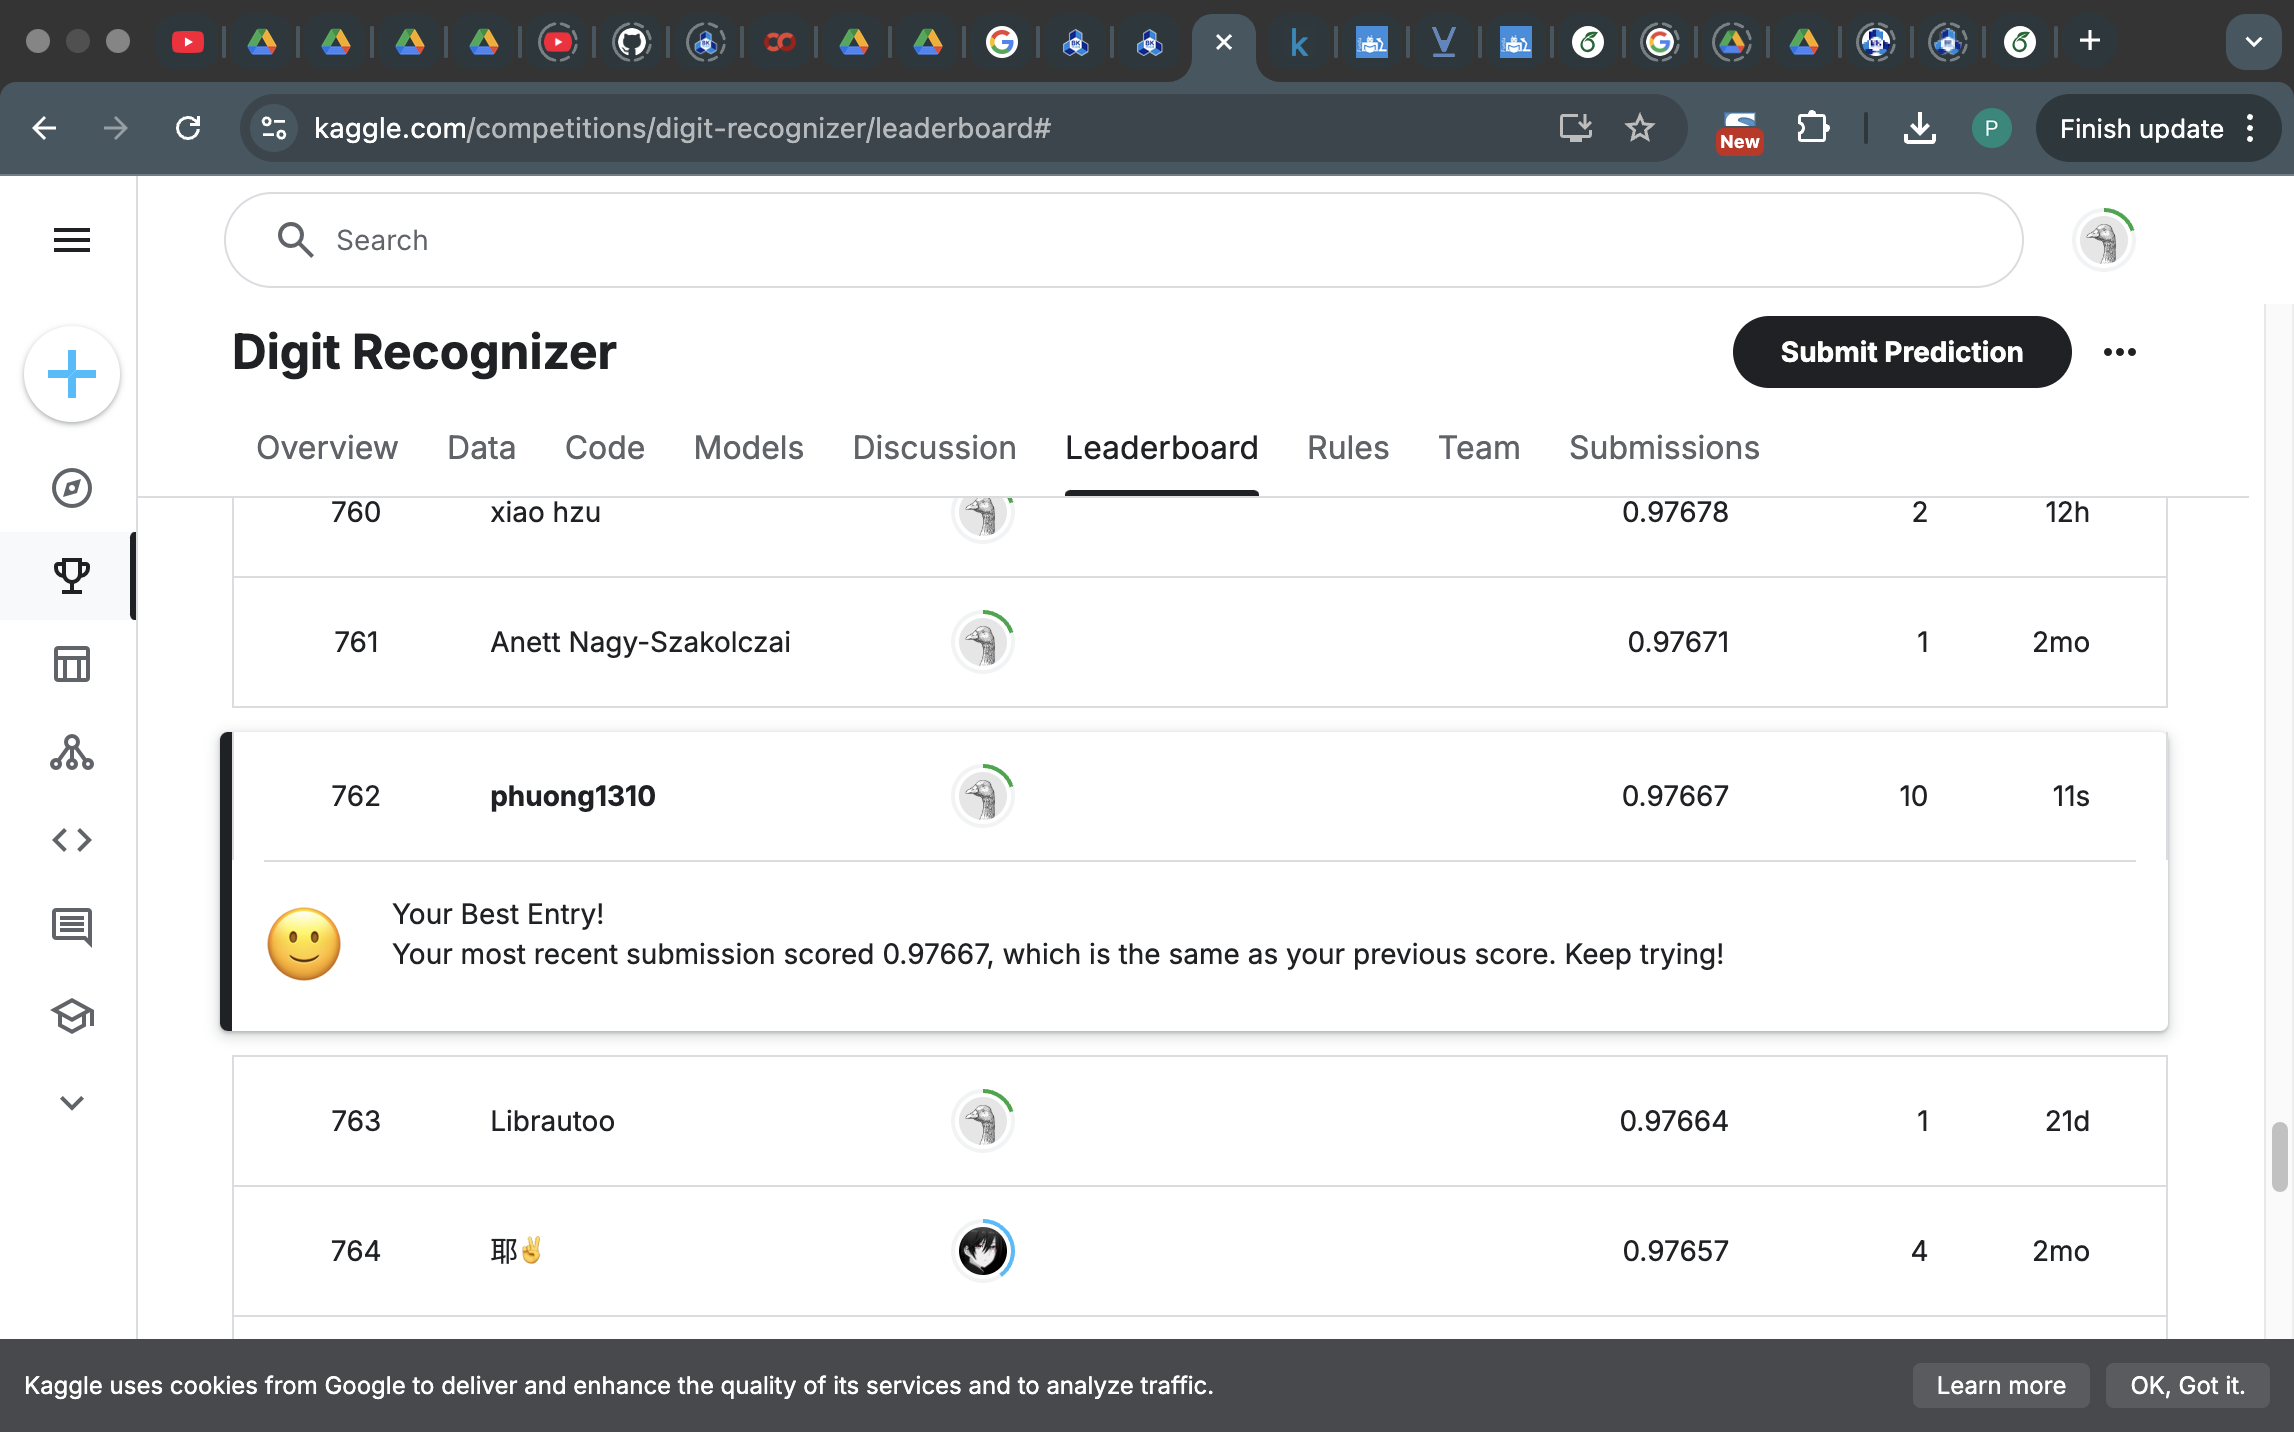

In [66]:
from IPython.display import Image

Image(filename='/Users/phuong/Desktop/hcmut/242/Natural_language_processing/[NLP]lab7/Screenshot 2025-03-20 at 02.14.57.png')
